In [ ]:
# Standard Import Stuff

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans

from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Data Files/cleaned_rq1.csv"

rq1_df = pd.read_csv(path)
print(rq1_df.shape)
print(rq1_df.describe())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(19166, 7)
       family_violence   tract_geoid  resolution_days
count     19166.000000  1.916600e+04     19166.000000
mean          0.143014  4.845301e+10        11.976364
std           0.350096  1.851634e+04        61.086549
min           0.000000  4.845300e+10        -3.000000
25%           0.000000  4.845300e+10        -1.000000
50%           0.000000  4.845300e+10         0.000000
75%           0.000000  4.845304e+10         4.000000
max           1.000000  4.845305e+10      2386.000000


In [ ]:
# There are negative values for resolution time. Not possible, potential datetime errors from pulled dataset.
# Will set all values < 0 to = 0, assuming same day resolution.
# Additionally, with a mean of 11.97 for resolution_days and a stdev of 61.08, that is heavily skewed by high outliers
# Due to the heavily-right skewing, will perform log transform to lessen the influence of outliers.

rq1_df.loc[rq1_df['resolution_days'] < 0, 'resolution_days'] = 0

rq1_df.describe(include='all')

,offense,family_violence,location_type,tract_geoid,occurred_datetime,report_datetime,resolution_days
count,19166,19166.000000,19166,1.916600e+04,19166,19166,19166.000000
unique,6,NaN,38,NaN,19075,19091,NaN
top,PUBLIC_ORDER,NaN,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,NaN,2016-04-05 18:00:00,2021-07-31 12:24:00,NaN
freq,5032,NaN,8655,NaN,3,2,NaN
mean,NaN,0.143014,NaN,4.845301e+10,NaN,NaN,12.456694
std,NaN,0.350096,NaN,1.851634e+04,NaN,NaN,60.986467
min,NaN,0.000000,NaN,4.845300e+10,NaN,NaN,0.000000
25%,NaN,0.000000,NaN,4.845300e+10,NaN,NaN,0.000000
50%,NaN,0.000000,NaN,4.845300e+10,NaN,NaN,0.000000
75%,NaN,0.000000,NaN,4.845304e+10,NaN,NaN,4.000000


In [ ]:
rq1_df['is_long'] = (rq1_df['resolution_days'] > 30).astype(int)

In [ ]:
print(rq1_df['resolution_days'].value_counts())

print(rq1_df['is_long'].value_counts())

resolution_days
0.0      12565
1.0        721
2.0        556
3.0        490
4.0        428
         ...  
416.0        1
834.0        1
494.0        1
282.0        1
343.0        1
Name: count, Length: 358, dtype: int64
is_long
0    17517
1     1649
Name: count, dtype: int64


In [ ]:
rq1_df.shape


(19166, 8)

In [ ]:
# Assumption is that the post-pandemic data will differ greatly and thus skew the train/test split.
# To remedy this we will split the dataframe into our two timelines suggested from EDA: 2016-2019 and 2020-2023.

rq1_df['occurred_datetime'] = pd.to_datetime(rq1_df['occurred_datetime'])
rq1_df['report_datetime'] = pd.to_datetime(rq1_df['report_datetime'])

rq1_time1_df = rq1_df[(rq1_df['occurred_datetime'].dt.year >= 2016) & (rq1_df['occurred_datetime'].dt.year <= 2019)]
rq1_time2_df = rq1_df[(rq1_df['occurred_datetime'].dt.year >= 2020) & (rq1_df['occurred_datetime'].dt.year <= 2023)]

print("2016-2019 Shape: ", rq1_time1_df.shape)
print("2020-2023 Shape: ", rq1_time2_df.shape)

2016-2019 Shape:  (12209, 8)
2020-2023 Shape:  (6957, 8)


In [ ]:
# Now to prepare for modeling we have to split the data for training and testing
# Because we are planning to compare the performance of multiple models, we will use a 70/30 split
# We are operating off of 2 different dataframes now, 3 if we include the original which should remain unchanged.
# Features to choose from are 'offense', 'family_violence', 'location_type', 'tract_geoid'
# Target variable is 'resolution_days'
# Random state is Pi, everyone loves Pi.

X1 = pd.get_dummies(rq1_time1_df[['offense', 'location_type', 'tract_geoid', 'family_violence']], drop_first=True)
y1 = np.log1p(rq1_time1_df['resolution_days'])

X2 = pd.get_dummies(rq1_time2_df[['offense', 'location_type', 'tract_geoid', 'family_violence']], drop_first=True)
y2 = np.log1p(rq1_time2_df['resolution_days'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=314)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=314)

In [ ]:
regressor_1 = LinearRegression().fit(X1_train, y1_train)
regressor_2 = LinearRegression().fit(X2_train, y2_train)

y1_pred = regressor_1.predict(X1_test)
y2_pred = regressor_2.predict(X2_test)

#y1_test_days = np.expm1(y1_test)
#y1_pred_days = np.expm1(y1_pred)


print("Timeline 1 - Mean Squared Error: ", round(mean_squared_error(y1_test, y1_pred),3))
print("Timeline 1 - R Squared: ", round(r2_score(y1_test, y1_pred),3))

print("Timeline 2 - Mean Squared Error: ", round(mean_squared_error(y2_test, y2_pred),3))
print("Timeline 2 - R Squared: ", round(r2_score(y2_test, y2_pred),3))

Timeline 1 - Mean Squared Error:  2.176
Timeline 1 - R Squared:  0.028
Timeline 2 - Mean Squared Error:  1.468
Timeline 2 - R Squared:  0.06


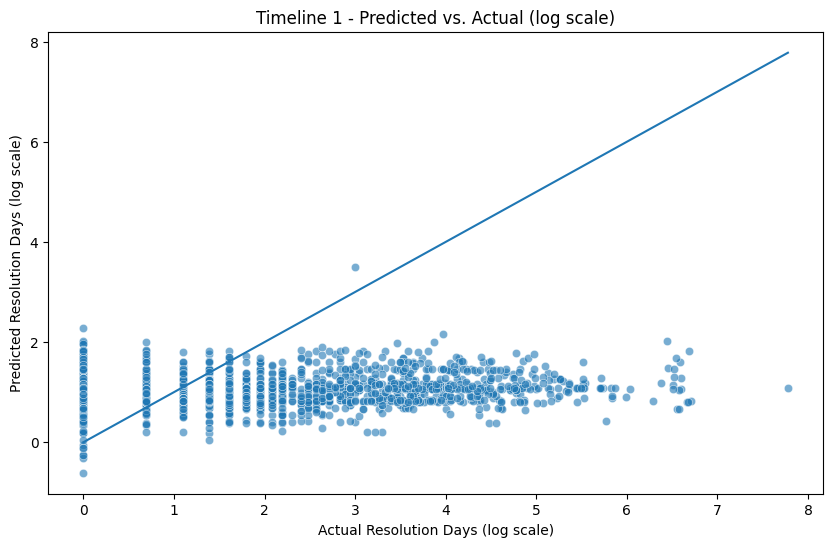

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y1_test, y=y1_pred, alpha=0.6)

plt.plot([y1_test.min(), y1_test.max()],
         [y1_test.min(), y1_test.max()])

plt.xlabel('Actual Resolution Days (log scale)')
plt.ylabel('Predicted Resolution Days (log scale)')
plt.title('Timeline 1 - Predicted vs. Actual (log scale)')

plt.show()

In [ ]:
# Wow the lin reg is terrible, let's categorize!
# is_long for resolution_days > 30


X1_log = pd.get_dummies(rq1_time1_df[['offense', 'location_type',]])# 'tract_geoid',]])#]] 'family_violence']])
X2_log = pd.get_dummies(rq1_time2_df[['offense', 'location_type',]])# 'tract_geoid',]])# 'family_violence']])
y1_long = rq1_time1_df['is_long']
y2_long = rq1_time2_df['is_long']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1_log, y1_long, test_size=0.3, random_state=314)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_log, y2_long, test_size=0.3, random_state=314)

log_model1 = LogisticRegression(class_weight='balanced')
log_model2 = LogisticRegression(class_weight='balanced')
log_model1.fit(X1_train, y1_train)
log_model2.fit(X2_train, y2_train)

y1_log_pred = log_model1.predict(X1_test)
y2_log_pred = log_model2.predict(X2_test)

In [ ]:
print(classification_report(y1_test, y1_log_pred))
print(classification_report(y2_test, y2_log_pred))

              precision    recall  f1-score   support

           0       0.93      0.54      0.68      3298
           1       0.13      0.64      0.22       365

    accuracy                           0.55      3663
   macro avg       0.53      0.59      0.45      3663
weighted avg       0.85      0.55      0.63      3663

              precision    recall  f1-score   support

           0       0.96      0.54      0.69      1954
           1       0.09      0.66      0.16       134

    accuracy                           0.54      2088
   macro avg       0.52      0.60      0.42      2088
weighted avg       0.90      0.54      0.65      2088



In [ ]:
print("Train distribution:", np.bincount(y1_train))
print("Test distribution:", np.bincount(y1_test))
print("Predicted labels:", np.bincount(y1_log_pred))


Train distribution: [7661  885]
Test distribution: [3298  365]
Predicted labels: [1897 1766]


In [ ]:
y1_log_prob = log_model1.predict_proba(X1_test)[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y1_test, y1_log_prob)
auc1 = roc_auc_score(y1_test, y1_log_prob)

y2_log_prob = log_model2.predict_proba(X2_test)[:, 1]
fpr2, tpr2, thresholds2 = roc_curve(y2_test, y2_log_prob)
auc2 = roc_auc_score(y2_test, y2_log_prob)

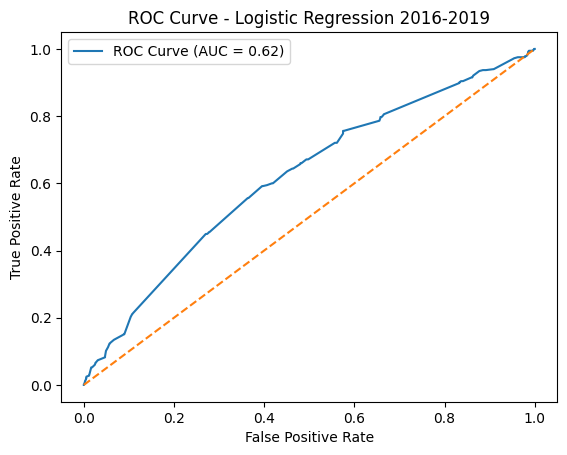

In [ ]:
plt.plot(fpr1, tpr1, label=f'ROC Curve (AUC = {auc1:.2f})')
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression 2016-2019')
plt.legend()
plt.show()

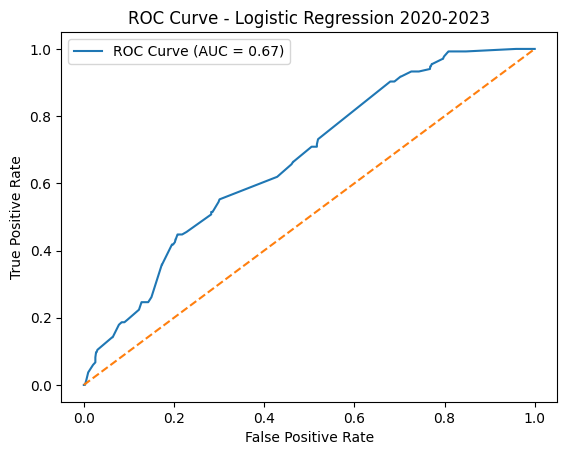

In [ ]:
plt.plot(fpr2, tpr2, label=f'ROC Curve (AUC = {auc2:.2f})')
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression 2020-2023')
plt.legend()
plt.show()